# Convolutional Neural Network (CNN)

### Import libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
from tensorflow.keras import datasets, layers, models
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# augment training set
datagen = tf.compat.v2.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    #vertical_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1)
for i in range(len(train_images)):
  augment = datagen.random_transform(x=train_images[i],seed=i)
  train_images[i]=augment

# Normalize pixel values to be between 0 and 1
  
train_images, test_images = train_images/255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


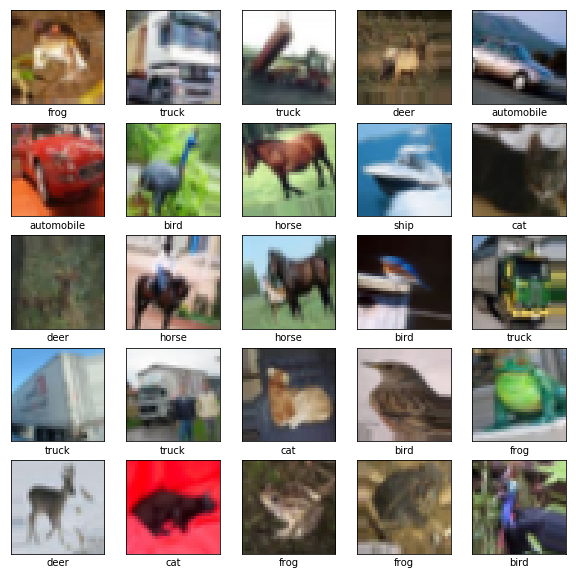

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels are arrays, 
    # which is why we need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the CNN.

In [ ]:
# Val_acc = 0.73. Decent, but impossible to squeeze any performance from that one. 
# The main reason: overfitting. For a multi-class model like that, the train-test accuracy difference was .15-.2. 
# That's why the next model is used (implemented from the VGG paper-see below) (which exhibits a val_acc~.9), with heavy dropout and penalty implementation through regularizing.
# NOTE: the image augmentation was with random_transform and not fit->flow from data etc. Reason being, the file system in Colab is quirky and 
#       didn't want to download files to Drive.

"""
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.compat.v2.keras.layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(tf.compat.v2.keras.layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(tf.compat.v2.keras.layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))
"""
     
# Build the network of vgg for 10 classes with massive dropout and weight decay as described in this paper: https://arxiv.org/pdf/1409.1556.pdf.
num_classes = 10
weight_decay = 0.0005
x_shape = [32,32,3]

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
        
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
        
model.add(layers.MaxPooling2D((2, 2)))
        
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
        
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
        
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(tf.compat.v2.keras.layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

###Architecture

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

###Training parameters

In [ ]:
#training parameters
batch_size = 200
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

###Callbacks

In [ ]:
#callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './drive/My Drive/weights.hdf5', verbose = 0, save_best_only = True)

def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

###Optimization

In [9]:
#optimization details
sgd = tf.compat.v2.keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

if os.path.exists('./drive/My Drive/cifar10.h5'):
  model.load_weights('./drive/My Drive/cifar10.h5')
  print("model loaded successfully")
elif os.path.exists('./drive/My Drive/weights.hdf5'):
  model.load_weights('./drive/My Drive/weights.hdf5')
  print("weights loaded successfully")
else: print ("Nothing to upload")

weights loaded successfully


### Compile and train the model

In [10]:
history = model.fit(train_images, train_labels,batch_size=batch_size, 
                            steps_per_epoch=len(train_images) // batch_size,
                            epochs=maxepoches, validation_steps = len(test_images)// batch_size,
                            validation_data=(test_images, test_labels),callbacks=[reduce_lr, checkpointer],verbose=2)

model.save_weights('./drive/My Drive/cifar10.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 - 69s - loss: 1.5072 - accuracy: 0.8048 - val_loss: 1.5054 - val_accuracy: 0.8049
Epoch 2/250
50000/50000 - 57s - loss: 1.5237 - accuracy: 0.8042 - val_loss: 1.5729 - val_accuracy: 0.7820
Epoch 3/250
50000/50000 - 57s - loss: 1.5183 - accuracy: 0.8030 - val_loss: 1.6970 - val_accuracy: 0.7386
Epoch 4/250
50000/50000 - 57s - loss: 1.5194 - accuracy: 0.8050 - val_loss: 1.7766 - val_accuracy: 0.7241
Epoch 5/250
50000/50000 - 57s - loss: 1.5246 - accuracy: 0.8058 - val_loss: 1.8155 - val_accuracy: 0.7112
Epoch 6/250
50000/50000 - 57s - loss: 1.5279 - accuracy: 0.8036 - val_loss: 1.5418 - val_accuracy: 0.8006
Epoch 7/250
50000/50000 - 59s - loss: 1.5160 - accuracy: 0.8052 - val_loss: 1.4711 - val_accuracy: 0.8199
Epoch 8/250
50000/50000 - 57s - loss: 1.5318 - accuracy: 0.8038 - val_loss: 1.9364 - val_accuracy: 0.6950
Epoch 9/250
50000/50000 - 57s - loss: 1.5289 - accuracy: 0.8028 - val_loss: 1.5915 - val_accuracy: 0.7

### Evaluate the model

10000/1 - 8s - loss: 0.5321 - accuracy: 0.8987


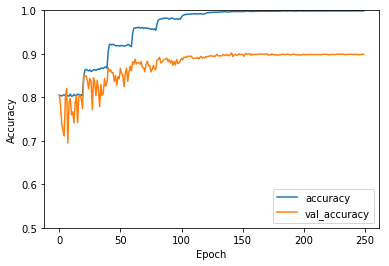

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
print(test_acc)

0.8987
